# **Imports**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
!pip install catboost
import catboost
import matplotlib.pyplot as plt
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 65.4 MB/s 


# **Reading input data**

In [ ]:
df_main = pd.read_csv('/content/drive/MyDrive/Dataset_Open_Items_EN.csv', sep=";")
df = df_main.copy()

In [ ]:
df_main

,amount,Payment_period,due_date_month-end,Payment_delay,N_items,N_items_late,N_items_on_time,N_items_late_to_on_time,N_items_running,N_items_running_late,...,headquarter_Nordrhein-Westfalen,headquarter_Rheinland-Pfalz,headquarter_Sachsen,headquarter_Sachsen-Anhalt,headquarter_Schleswig-Holstein,headquarter_Thueringen,headquarter_-1,headquarter_Brandenburg,headquarter_Mecklenburg-Vorpommern,headquarter_Saarland
0,-0.074,0.141,1.494,0,1.125,0.005,1.751,-0.140,-0.024,-0.248,...,-0.789,-0.14,-0.173,-0.11,-0.181,-0.151,-0.068,-0.109,-0.09,-0.068
1,-0.287,0.141,1.494,0,1.125,0.005,1.751,-0.140,-0.024,-0.248,...,-0.789,-0.14,-0.173,-0.11,-0.181,-0.151,-0.068,-0.109,-0.09,-0.068
2,-0.259,0.141,-0.669,0,1.125,0.005,1.751,-0.140,0.408,-0.248,...,-0.789,-0.14,-0.173,-0.11,-0.181,-0.151,-0.068,-0.109,-0.09,-0.068
3,-0.310,0.141,-0.669,0,1.125,0.005,1.751,-0.140,0.408,-0.248,...,-0.789,-0.14,-0.173,-0.11,-0.181,-0.151,-0.068,-0.109,-0.09,-0.068
4,0.302,0.141,-0.669,0,1.125,0.005,1.751,-0.140,0.840,-0.248,...,-0.789,-0.14,-0.173,-0.11,-0.181,-0.151,-0.068,-0.109,-0.09,-0.068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,-0.127,-0.403,-0.669,0,-0.525,-0.400,-0.489,-0.109,-0.455,-0.248,...,1.267,-0.14,-0.173,-0.11,-0.181,-0.151,-0.068,-0.109,-0.09,-0.068
39996,-0.127,-0.403,-0.669,0,-0.521,-0.400,-0.483,-0.127,-0.455,-0.248,...,1.267,-0.14,-0.173,-0.11,-0.181,-0.151,-0.068,-0.109,-0.09,-0.068
39997,-0.059,0.243,-0.669,0,-0.529,-0.408,-0.489,-0.146,-0.455,-0.248,...,-0.789,-0.14,5.788,-0.11,-0.181,-0.151,-0.068,-0.109,-0.09,-0.068
39998,-0.203,0.311,-0.669,0,-0.525,-0.408,-0.483,-0.146,-0.455,-0.248,...,-0.789,-0.14,5.788,-0.11,-0.181,-0.151,-0.068,-0.109,-0.09,-0.068


In [ ]:
df.shape

(40000, 164)

In [ ]:
df.dtypes

amount                                float64
Payment_period                        float64
due_date_month-end                    float64
Payment_delay                          object
N_items                               float64
                                       ...   
headquarter_Thueringen                float64
headquarter_-1                        float64
headquarter_Brandenburg               float64
headquarter_Mecklenburg-Vorpommern    float64
headquarter_Saarland                  float64
Length: 164, dtype: object

# **Data Pre-processing**

In [ ]:
#To check for duplicate values
df.drop_duplicates(keep="first",inplace=True)

In [ ]:
df.shape #proves some duplicate rows are present

(39952, 164)

In [ ]:
#To check for null values
df.isnull().any().value_counts()

False    164
dtype: int64

In [ ]:
df.fillna(method="ffill",inplace=True)

In [ ]:
df['Payment_delay'].value_counts()

0        24362
1-30     14306
31-60      954
61-90      203
>90        127
Name: Payment_delay, dtype: int64

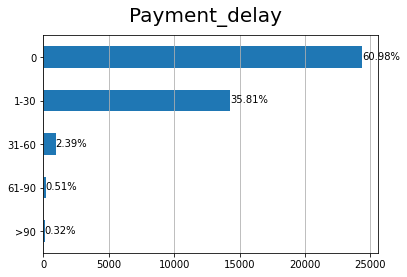

In [ ]:
#Target distribution in dataset

ax = df['Payment_delay'].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20,
     str(round((i.get_width()/total)*100, 2))+'%',
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle('Payment_delay', fontsize=20)
plt.show()

In [ ]:
#Converting target column to categorical
LE = LabelEncoder()
df['Payment_delay'] = LE.fit_transform(df['Payment_delay'])

In [ ]:
df['Payment_delay'].value_counts()

0    24362
1    14306
2      954
3      203
4      127
Name: Payment_delay, dtype: int64

In [ ]:
#Distribution of float and int datatypes in the dataset
df.dtypes.value_counts()

float64    163
int64        1
dtype: int64

**Normalization and Standardization of dataset**

In [ ]:
#Normalization of dataset
norm = MinMaxScaler().fit_transform(df.drop('Payment_delay',axis=1).values)
pd.DataFrame(norm)

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,162
0,0.006374,0.026123,1.0,0.298201,0.060753,0.298194,0.000233,0.041606,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000810,0.026123,1.0,0.298201,0.060753,0.298194,0.000233,0.041606,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001541,0.026123,0.0,0.298201,0.060753,0.298194,0.000233,0.083309,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000209,0.026123,0.0,0.298201,0.060753,0.298194,0.000233,0.083309,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.016195,0.026123,0.0,0.298201,0.060753,0.298194,0.000233,0.125012,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39947,0.004989,0.011710,0.0,0.001439,0.001177,0.000797,0.001439,0.000000,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39948,0.004989,0.011710,0.0,0.002158,0.001177,0.001593,0.000739,0.000000,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39949,0.006765,0.028826,0.0,0.000719,0.000000,0.000797,0.000000,0.000000,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39950,0.003004,0.030627,0.0,0.001439,0.000000,0.001593,0.000000,0.000000,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Data Standardization
sc = StandardScaler()
std = sc.fit_transform(norm)
std

array([[-0.06638573,  0.12657164,  1.48453671, ..., -0.109458  ,
        -0.09773293, -0.05396238],
       [-0.26482817,  0.12657164,  1.48453671, ..., -0.109458  ,
        -0.09773293, -0.05396238],
       [-0.23874184,  0.12657164, -0.67361083, ..., -0.109458  ,
        -0.09773293, -0.05396238],
       ...,
       [-0.05241091,  0.22762218, -0.67361083, ..., -0.109458  ,
        -0.09773293, -0.05396238],
       [-0.18656918,  0.29498921, -0.67361083, ..., -0.109458  ,
        -0.09773293, -0.05396238],
       [-0.1902958 , -0.37868108,  1.48453671, ..., -0.109458  ,
        -0.09773293, -0.05396238]])

In [ ]:
X_nstd = pd.DataFrame(std)
X_nstd

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,162
0,-0.066386,0.126572,1.484537,0.941304,-0.064910,1.547051,-0.146771,-0.105832,-0.262071,-0.341966,...,-0.782185,-0.133736,-0.189857,-0.098383,-0.197029,-0.166684,-0.048821,-0.109458,-0.097733,-0.053962
1,-0.264828,0.126572,1.484537,0.941304,-0.064910,1.547051,-0.146771,-0.105832,-0.262071,-0.341966,...,-0.782185,-0.133736,-0.189857,-0.098383,-0.197029,-0.166684,-0.048821,-0.109458,-0.097733,-0.053962
2,-0.238742,0.126572,-0.673611,0.941304,-0.064910,1.547051,-0.146771,0.283596,-0.262071,-0.341966,...,-0.782185,-0.133736,-0.189857,-0.098383,-0.197029,-0.166684,-0.048821,-0.109458,-0.097733,-0.053962
3,-0.286256,0.126572,-0.673611,0.941304,-0.064910,1.547051,-0.146771,0.283596,-0.262071,-0.341966,...,-0.782185,-0.133736,-0.189857,-0.098383,-0.197029,-0.166684,-0.048821,-0.109458,-0.097733,-0.053962
4,0.283916,0.126572,-0.673611,0.941304,-0.064910,1.547051,-0.146771,0.673024,-0.262071,-0.341966,...,-0.782185,-0.133736,-0.189857,-0.098383,-0.197029,-0.166684,-0.048821,-0.109458,-0.097733,-0.053962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39947,-0.115763,-0.412365,-0.673611,-0.553542,-0.424809,-0.514244,-0.111336,-0.494358,-0.262071,-0.341966,...,1.278471,-0.133736,-0.189857,-0.098383,-0.197029,-0.166684,-0.048821,-0.109458,-0.097733,-0.053962
39948,-0.115763,-0.412365,-0.673611,-0.549918,-0.424809,-0.508723,-0.131911,-0.494358,-0.262071,-0.341966,...,1.278471,-0.133736,-0.189857,-0.098383,-0.197029,-0.166684,-0.048821,-0.109458,-0.097733,-0.053962
39949,-0.052411,0.227622,-0.673611,-0.557166,-0.431918,-0.514244,-0.153629,-0.494358,-0.262071,-0.341966,...,-0.782185,-0.133736,5.267110,-0.098383,-0.197029,-0.166684,-0.048821,-0.109458,-0.097733,-0.053962
39950,-0.186569,0.294989,-0.673611,-0.553542,-0.431918,-0.508723,-0.153629,-0.494358,-0.262071,-0.341966,...,-0.782185,-0.133736,5.267110,-0.098383,-0.197029,-0.166684,-0.048821,-0.109458,-0.097733,-0.053962


In [ ]:
X = pd.concat([X_nstd, df['Payment_delay']],axis=1, join='inner')
X

,0,1,2,3,4,5,6,7,8,9,...,154,155,156,157,158,159,160,161,162,Payment_delay
0,-0.066386,0.126572,1.484537,0.941304,-0.064910,1.547051,-0.146771,-0.105832,-0.262071,-0.341966,...,-0.133736,-0.189857,-0.098383,-0.197029,-0.166684,-0.048821,-0.109458,-0.097733,-0.053962,0
1,-0.264828,0.126572,1.484537,0.941304,-0.064910,1.547051,-0.146771,-0.105832,-0.262071,-0.341966,...,-0.133736,-0.189857,-0.098383,-0.197029,-0.166684,-0.048821,-0.109458,-0.097733,-0.053962,0
2,-0.238742,0.126572,-0.673611,0.941304,-0.064910,1.547051,-0.146771,0.283596,-0.262071,-0.341966,...,-0.133736,-0.189857,-0.098383,-0.197029,-0.166684,-0.048821,-0.109458,-0.097733,-0.053962,0
3,-0.286256,0.126572,-0.673611,0.941304,-0.064910,1.547051,-0.146771,0.283596,-0.262071,-0.341966,...,-0.133736,-0.189857,-0.098383,-0.197029,-0.166684,-0.048821,-0.109458,-0.097733,-0.053962,0
4,0.283916,0.126572,-0.673611,0.941304,-0.064910,1.547051,-0.146771,0.673024,-0.262071,-0.341966,...,-0.133736,-0.189857,-0.098383,-0.197029,-0.166684,-0.048821,-0.109458,-0.097733,-0.053962,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39947,-0.115763,-0.412365,-0.673611,-0.553542,-0.424809,-0.514244,-0.111336,-0.494358,-0.262071,-0.341966,...,-0.133736,-0.189857,-0.098383,-0.197029,-0.166684,-0.048821,-0.109458,-0.097733,-0.053962,1
39948,-0.115763,-0.412365,-0.673611,-0.549918,-0.424809,-0.508723,-0.131911,-0.494358,-0.262071,-0.341966,...,-0.133736,-0.189857,-0.098383,-0.197029,-0.166684,-0.048821,-0.109458,-0.097733,-0.053962,1
39949,-0.052411,0.227622,-0.673611,-0.557166,-0.431918,-0.514244,-0.153629,-0.494358,-0.262071,-0.341966,...,-0.133736,5.267110,-0.098383,-0.197029,-0.166684,-0.048821,-0.109458,-0.097733,-0.053962,1
39950,-0.186569,0.294989,-0.673611,-0.553542,-0.431918,-0.508723,-0.153629,-0.494358,-0.262071,-0.341966,...,-0.133736,5.267110,-0.098383,-0.197029,-0.166684,-0.048821,-0.109458,-0.097733,-0.053962,1


In [ ]:
#Splitting dataset to form validation set
def split(df):
  x_train, x_val, y_train, y_val = train_test_split(df.drop(['Payment_delay'], axis=1), \
                                                  df['Payment_delay'].astype('int'),
                                                    test_size=0.20,shuffle=True,
                                                    random_state=0,
                                                    stratify=df['Payment_delay'])
  return x_train, x_val, y_train, y_val

In [ ]:
#Prediction report
from sklearn.metrics import matthews_corrcoef
def evaluate_model(y_true, y_pred, index_values):
  print('Classification report')
  print('-'*75)
  print(classification_report(y_true,y_pred))
  print('Confusion matrix')
  print('-'*75)
  cm = confusion_matrix(y_true, y_pred)
  cm_df = pd.DataFrame(cm.T, index=index_values, columns=index_values)
  cm_df.index.name = 'Predicted'
  cm_df.columns.name = 'True'
  print(cm_df)
  print('')
  print('Matthew Correlation coefficient')
  print('-'*75)
  print( matthews_corrcoef(y_true, y_pred))

In [ ]:
#Over sampling and under sampling
def sampling_strategy(kind = "SMOTETOMEK"):
  if(kind == "SMOTE"):
    oversample = SMOTE(random_state=42)
    X, y = oversample.fit_resample(x_train, y_train)
  else:
    smt = SMOTETomek(random_state=42)
    X, y = smt.fit_resample(x_train, y_train)

  return X,y

In [ ]:
#Class-wise distribution of target field
x_train, x_test, y_train, y_test = split(X)
train = pd.concat([x_train,y_train],axis=1)
test = pd.concat([x_test, y_test],axis=1)
print("Train dataset")
print(train['Payment_delay'].value_counts())
print("Test dataset")
print(test['Payment_delay'].value_counts())

Train dataset
0    19458
1    11438
2      763
3      162
4      102
Name: Payment_delay, dtype: int64
Test dataset
0    4865
1    2859
2     191
3      41
4      25
Name: Payment_delay, dtype: int64


# **Model Baseline**

(a) LGBM classifier

In [ ]:
model1 = lgb.LGBMClassifier(random_state=0, n_estimators=500,
                           learning_rate=0.1, num_leaves=31,
                           is_unbalance=True)

In [ ]:
index_values = list(train.sort_values(by="Payment_delay")['Payment_delay'].unique())
x_train, x_val, y_train, y_val = split(train)

model1.fit(x_train, y_train, eval_set=(x_val,y_val), verbose=0)
val_pred = model1.predict(x_val)

evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.86      0.78      3892
           1       0.62      0.43      0.51      2288
           2       0.38      0.12      0.18       153
           3       0.27      0.09      0.14        32
           4       0.17      0.05      0.08        20

    accuracy                           0.68      6385
   macro avg       0.43      0.31      0.34      6385
weighted avg       0.67      0.68      0.66      6385

Confusion matrix
---------------------------------------------------------------------------
True          0     1   2   3   4
Predicted                        
0          3362  1279  73  19  15
1           519   981  59  10   3
2             8    22  18   0   0
3             2     3   2   3   1
4             1     3   1   0   1

Matthew Correlation coefficient
-------------------------------------------------

(b) Random Forest Classifier

In [ ]:
model2 = RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
index_values = list(train.sort_values(by="Payment_delay")['Payment_delay'].unique())
x_train, x_val, y_train, y_val = split(train)

model2.fit(x_train, y_train)
val_pred = model2.predict(x_val)

evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      1.00      0.76      3892
           1       0.79      0.00      0.01      2288
           2       0.00      0.00      0.00       153
           3       0.00      0.00      0.00        32
           4       0.00      0.00      0.00        20

    accuracy                           0.61      6385
   macro avg       0.28      0.20      0.15      6385
weighted avg       0.65      0.61      0.47      6385

Confusion matrix
---------------------------------------------------------------------------
True          0     1    2   3   4
Predicted                         
0          3889  2277  153  32  20
1             3    11    0   0   0
2             0     0    0   0   0
3             0     0    0   0   0
4             0     0    0   0   0

Matthew Correlation coefficient
------------------------------------------

(c) Catboost Classifier

In [ ]:
model3 = catboost.CatBoostClassifier(n_estimators=2500,random_state=0, learning_rate=0.03, verbose=100, early_stopping_rounds=50,auto_class_weights="Balanced")

In [ ]:
index_values = list(train.sort_values(by="Payment_delay")['Payment_delay'].unique())
x_train, x_val, y_train, y_val = split(train)

model3.fit(x_train, y_train)
val_pred = model3.predict(x_val)

evaluate_model(y_val, val_pred, index_values)

0:	learn: 1.6033206	total: 116ms	remaining: 4m 49s
100:	learn: 1.2782714	total: 5.58s	remaining: 2m 12s
200:	learn: 1.1182104	total: 11s	remaining: 2m 6s
300:	learn: 1.0040625	total: 16.6s	remaining: 2m 1s
400:	learn: 0.8927708	total: 24.1s	remaining: 2m 6s
500:	learn: 0.7940240	total: 29.6s	remaining: 1m 58s
600:	learn: 0.7232505	total: 35.5s	remaining: 1m 52s
700:	learn: 0.6688025	total: 41.8s	remaining: 1m 47s
800:	learn: 0.6253095	total: 47.2s	remaining: 1m 40s
900:	learn: 0.5885245	total: 52.7s	remaining: 1m 33s
1000:	learn: 0.5595472	total: 58.2s	remaining: 1m 27s
1100:	learn: 0.5339563	total: 1m 3s	remaining: 1m 20s
1200:	learn: 0.5130819	total: 1m 9s	remaining: 1m 14s
1300:	learn: 0.4932190	total: 1m 14s	remaining: 1m 8s
1400:	learn: 0.4756562	total: 1m 19s	remaining: 1m 2s
1500:	learn: 0.4598861	total: 1m 25s	remaining: 56.8s
1600:	learn: 0.4450983	total: 1m 30s	remaining: 51s
1700:	learn: 0.4316591	total: 1m 36s	remaining: 45.2s
1800:	learn: 0.4202202	total: 1m 41s	remaining:

# **SMOTE AND SMOTETOMEK sampling strategy on classifiers**

**(a) On LGBM classifier**

(i) SMOTE sampling strategy

In [ ]:
index_values = list(train.sort_values(by="Payment_delay")['Payment_delay'].unique())
x_train, x_val, y_train, y_val = split(train)

X,y = sampling_strategy("SMOTE")
model1.fit(X, y, eval_set=(x_val,y_val), verbose=0)
val_pred = model1.predict(x_val)

evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.84      0.77      3892
           1       0.61      0.46      0.52      2288
           2       0.32      0.10      0.15       153
           3       0.40      0.19      0.26        32
           4       0.40      0.10      0.16        20

    accuracy                           0.68      6385
   macro avg       0.49      0.34      0.37      6385
weighted avg       0.66      0.68      0.66      6385

Confusion matrix
---------------------------------------------------------------------------
True          0     1   2   3   4
Predicted                        
0          3279  1218  72  19  15
1           600  1046  59   7   3
2            11    21  15   0   0
3             1     3   5   6   0
4             1     0   2   0   2

Matthew Correlation coefficient
-------------------------------------------------

(ii) SMOTETOMEK sampling strategy

In [ ]:
index_values = list(train.sort_values(by="Payment_delay")['Payment_delay'].unique())
x_train, x_val, y_train, y_val = split(train)

X,y = sampling_strategy("SMOTETOMEK")
model1.fit(X, y, eval_set=(x_val,y_val), verbose=0)
val_pred = model1.predict(x_val)

evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.85      0.77      3892
           1       0.61      0.42      0.50      2288
           2       0.31      0.11      0.16       153
           3       0.31      0.16      0.21        32
           4       0.00      0.00      0.00        20

    accuracy                           0.67      6385
   macro avg       0.39      0.31      0.33      6385
weighted avg       0.65      0.67      0.65      6385

Confusion matrix
---------------------------------------------------------------------------
True          0     1   2   3   4
Predicted                        
0          3310  1287  79  20  16
1           569   969  50   7   4
2             9    28  17   0   0
3             2     4   5   5   0
4             2     0   2   0   0

Matthew Correlation coefficient
-------------------------------------------------

**(b) Random Forest Classifier**

(i) SMOTE sampling strategy

In [ ]:
index_values = list(train.sort_values(by="Payment_delay")['Payment_delay'].unique())
x_train, x_val, y_train, y_val = split(train)

X,y = sampling_strategy("SMOTE")
model2.fit(X, y)
val_pred = model2.predict(x_val)

evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.74      0.69      3892
           1       0.44      0.06      0.11      2288
           2       0.06      0.13      0.08       153
           3       0.02      0.25      0.03        32
           4       0.00      0.15      0.01        20

    accuracy                           0.48      6385
   macro avg       0.23      0.27      0.18      6385
weighted avg       0.55      0.48      0.46      6385

Confusion matrix
---------------------------------------------------------------------------
True          0     1   2   3   4
Predicted                        
0          2880  1436  88  17  15
1           183   146   4   1   1
2           171   165  20   2   0
3           206   205  14   8   1
4           452   336  27   4   3

Matthew Correlation coefficient
-------------------------------------------------

(ii) SMOTETOMEK sampling strategy

In [ ]:
index_values = list(train.sort_values(by="Payment_delay")['Payment_delay'].unique())
x_train, x_val, y_train, y_val = split(train)

X,y = sampling_strategy("SMOTETOMEK")
model2.fit(X, y)
val_pred = model2.predict(x_val)

evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.55      0.60      3892
           1       0.62      0.01      0.02      2288
           2       0.03      0.27      0.06       153
           3       0.02      0.28      0.03        32
           4       0.00      0.15      0.00        20

    accuracy                           0.35      6385
   macro avg       0.27      0.25      0.14      6385
weighted avg       0.63      0.35      0.37      6385

Confusion matrix
---------------------------------------------------------------------------
True          0     1   2   3   4
Predicted                        
0          2130  1023  60  12  11
1            12    20   0   0   0
2           709   479  41   6   3
3           287   257  19   9   3
4           754   509  33   5   3

Matthew Correlation coefficient
-------------------------------------------------

**(c) Catboost classifier**

(i) SMOTE sampling strategy

In [ ]:
index_values = list(train.sort_values(by="Payment_delay")['Payment_delay'].unique())
x_train, x_val, y_train, y_val = split(train)

X,y = sampling_strategy("SMOTE")
model3.fit(X, y, eval_set=(x_val,y_val), verbose=0)
val_pred = model3.predict(x_val)

evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.83      0.76      3892
           1       0.59      0.43      0.50      2288
           2       0.23      0.10      0.14       153
           3       0.24      0.12      0.16        32
           4       0.11      0.05      0.07        20

    accuracy                           0.66      6385
   macro avg       0.37      0.31      0.33      6385
weighted avg       0.65      0.66      0.65      6385

Confusion matrix
---------------------------------------------------------------------------
True          0     1   2   3   4
Predicted                        
0          3244  1270  80  18  17
1           622   979  49   9   2
2            18    34  16   1   0
3             4     4   5   4   0
4             4     1   3   0   1

Matthew Correlation coefficient
-------------------------------------------------

(ii) SMOTETOMEK sampling strategy

In [ ]:
index_values = list(train.sort_values(by="Payment_delay")['Payment_delay'].unique())
x_train, x_val, y_train, y_val = split(train)

X,y = sampling_strategy("SMOTETOMEK")
model3.fit(X, y, eval_set=(x_val,y_val), verbose=0)
val_pred = model3.predict(x_val)

evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.84      0.76      3892
           1       0.59      0.42      0.49      2288
           2       0.24      0.10      0.15       153
           3       0.29      0.12      0.17        32
           4       0.08      0.05      0.06        20

    accuracy                           0.66      6385
   macro avg       0.38      0.31      0.33      6385
weighted avg       0.65      0.66      0.64      6385

Confusion matrix
---------------------------------------------------------------------------
True          0     1   2   3   4
Predicted                        
0          3265  1294  78  18  16
1           602   957  51   9   3
2            18    31  16   1   0
3             2     3   5   4   0
4             5     3   3   0   1

Matthew Correlation coefficient
-------------------------------------------------

# **One vs Rest dataset split on Classifiers**

**(a) LGBM Classifier- SMOTE sampling strategy**

In [ ]:
onevsrest = train.copy()
model1 = lgb.LGBMClassifier(class_weight="balanced")
onevsrest['Payment_delay'] = np.where(train['Payment_delay'] == 0, 0, 999)
x_train, x_val, y_train, y_val = split(onevsrest)
index_values = list(onevsrest['Payment_delay'].unique())

X, y = sampling_strategy("SMOTE")

model1.fit(X, y, eval_set=(x_val,y_val), verbose=0)
val_pred = model1.predict(x_val)
evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.85      0.77      3892
         999       0.64      0.42      0.51      2493

    accuracy                           0.68      6385
   macro avg       0.67      0.64      0.64      6385
weighted avg       0.68      0.68      0.67      6385

Confusion matrix
---------------------------------------------------------------------------
True        0     999
Predicted            
0          3319  1452
999         573  1041

Matthew Correlation coefficient
---------------------------------------------------------------------------
0.3034645773651928


In [ ]:
model_1 = lgb.LGBMClassifier(random_state=0, n_estimators=500,
                           learning_rate=0.1, num_leaves=31,
                           is_unbalance=True)
df.dropna(axis=1,inplace=True)
others = train[train['Payment_delay'] != 0]
index_values = list(others['Payment_delay'].unique())

x_train, x_val, y_train, y_val = split(others)

X, y = sampling_strategy("SMOTE")

model_1.fit(X, y, eval_set=(x_val,y_val), verbose=0)
val_pred = model_1.predict(x_val)
evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.93      0.99      0.96      2288
           2       0.43      0.12      0.19       153
           3       0.42      0.16      0.23        32
           4       0.67      0.30      0.41        20

    accuracy                           0.92      2493
   macro avg       0.61      0.39      0.45      2493
weighted avg       0.89      0.92      0.90      2493

Confusion matrix
---------------------------------------------------------------------------
True          1    2   3   4
Predicted                   
1          2260  131  23  14
2            22   19   3   0
3             5    2   5   0
4             1    1   1   6

Matthew Correlation coefficient
---------------------------------------------------------------------------
0.2657638307284758


In [ ]:
#Train
final_train = train.copy()
final_train['prediction'] = model1.predict(final_train[x_train.columns])
print(final_train['prediction'].value_counts())
print('')

one_class = final_train[final_train['prediction'] == 0]
other_class = final_train[final_train['prediction'] != 0]
other_class['prediction'] = model_1.predict(other_class[x_train.columns])
final_train_df = pd.concat([one_class, other_class],axis=0)
evaluate_model(final_train_df['Payment_delay'], final_train_df['prediction'], [0,1,2,3,4])

0      23757
999     8166
Name: prediction, dtype: int64

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.90      0.81     19458
           1       0.73      0.48      0.58     11438
           2       0.86      0.47      0.61       763
           3       0.87      0.51      0.65       162
           4       0.96      0.45      0.61       102

    accuracy                           0.73     31923
   macro avg       0.83      0.56      0.65     31923
weighted avg       0.73      0.73      0.72     31923

Confusion matrix
---------------------------------------------------------------------------
True           0     1    2   3   4
Predicted                          
0          17415  5902  326  63  51
1           1998  5511   72  14   5
2             39    20  362   2   0
3              6     4    2  83   0
4              0     1    1   0  46

Matthew C

In [ ]:
#Test
final_test = test.copy()
final_test['prediction'] = model1.predict(final_test[x_train.columns])
print(final_test['prediction'].value_counts())
print('')

one_class = final_test[final_test['prediction'] == 0]
other_class = final_test[final_test['prediction'] != 0]
other_class['prediction'] = model_1.predict(other_class[x_train.columns])
final_test_df = pd.concat([one_class, other_class],axis=0)
evaluate_model(final_test_df['Payment_delay'], final_test_df['prediction'], [0,1,2,3,4])

0      5928
999    2053
Name: prediction, dtype: int64

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.85      0.77      4865
           1       0.58      0.40      0.48      2859
           2       0.25      0.08      0.13       191
           3       0.33      0.15      0.20        41
           4       0.33      0.04      0.07        25

    accuracy                           0.67      7981
   macro avg       0.44      0.30      0.33      7981
weighted avg       0.64      0.67      0.64      7981

Confusion matrix
---------------------------------------------------------------------------
True          0     1   2   3   4
Predicted                        
0          4139  1675  88  16  10
1           705  1149  84  18  12
2            19    27  16   1   1
3             2     7   2   6   1
4             0     1   1   0   1

Matthew Correlation coeff

**(b) Random Forest Classifier - SMOTE sampling strategy**

In [ ]:
onevsrest = train.copy()
model2 = RandomForestClassifier(class_weight="balanced")
onevsrest['Payment_delay'] = np.where(train['Payment_delay'] == 0, 0, 999)
x_train, x_val, y_train, y_val = split(onevsrest)
index_values = list(onevsrest['Payment_delay'].unique())

X, y = sampling_strategy("SMOTE")

model2.fit(X, y)
val_pred = model2.predict(x_val)
evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.81      0.77      3892
         999       0.64      0.53      0.58      2493

    accuracy                           0.70      6385
   macro avg       0.69      0.67      0.68      6385
weighted avg       0.70      0.70      0.70      6385

Confusion matrix
---------------------------------------------------------------------------
True        0     999
Predicted            
0          3156  1162
999         736  1331

Matthew Correlation coefficient
---------------------------------------------------------------------------
0.3594921897888181


In [ ]:
model_2 = RandomForestClassifier(class_weight="balanced")
df.dropna(axis=1,inplace=True)
others = train[train['Payment_delay'] != 0]
index_values = list(others['Payment_delay'].unique())

x_train, x_val, y_train, y_val = split(others)

X, y = sampling_strategy("SMOTE")

model_2.fit(X, y)
val_pred = model_2.predict(x_val)
evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.93      0.98      0.96      2288
           2       0.39      0.18      0.24       153
           3       0.36      0.16      0.22        32
           4       0.60      0.30      0.40        20

    accuracy                           0.91      2493
   macro avg       0.57      0.40      0.45      2493
weighted avg       0.89      0.91      0.90      2493

Confusion matrix
---------------------------------------------------------------------------
True          1    2   3   4
Predicted                   
1          2241  122  24  13
2            38   27   3   1
3             6    3   5   0
4             3    1   0   6

Matthew Correlation coefficient
---------------------------------------------------------------------------
0.2732319602499524


In [ ]:
#Train
final_train = train.copy()
final_train['prediction'] = model2.predict(final_train[x_train.columns])
print(final_train['prediction'].value_counts())
print('')

one_class = final_train[final_train['prediction'] == 0]
other_class = final_train[final_train['prediction'] != 0]
other_class['prediction'] = model_2.predict(other_class[x_train.columns])
final_train_df = pd.concat([one_class, other_class],axis=0)
evaluate_model(final_train_df['Payment_delay'], final_train_df['prediction'], [0,1,2,3,4])

0      19882
999    12041
Name: prediction, dtype: int64

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     19458
           1       0.92      0.90      0.91     11438
           2       0.92      0.77      0.84       763
           3       0.93      0.77      0.84       162
           4       0.94      0.82      0.88       102

    accuracy                           0.93     31923
   macro avg       0.93      0.85      0.89     31923
weighted avg       0.93      0.93      0.93     31923

Confusion matrix
---------------------------------------------------------------------------
True           0      1    2    3   4
Predicted                            
0          18719   1088   57   11   7
1            723  10306  113   23  10
2             14     36  589    3   1
3              1      5    3  125   0
4              1      3    1    0 

In [ ]:
#Test
final_test = test.copy()
final_test['prediction'] = model2.predict(final_test[x_train.columns])
print(final_test['prediction'].value_counts())
print('')

one_class = final_test[final_test['prediction'] == 0]
other_class = final_test[final_test['prediction'] != 0]
other_class['prediction'] = model_2.predict(other_class[x_train.columns])
final_test_df = pd.concat([one_class, other_class],axis=0)
evaluate_model(final_test_df['Payment_delay'], final_test_df['prediction'], [0,1,2,3,4])

0      5333
999    2648
Name: prediction, dtype: int64

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.81      0.77      4865
           1       0.59      0.52      0.55      2859
           2       0.35      0.17      0.23       191
           3       0.27      0.15      0.19        41
           4       0.07      0.04      0.05        25

    accuracy                           0.68      7981
   macro avg       0.40      0.34      0.36      7981
weighted avg       0.67      0.68      0.68      7981

Confusion matrix
---------------------------------------------------------------------------
True          0     1    2   3   4
Predicted                         
0          3935  1323   55  11   9
1           898  1490  100  19  13
2            22    33   32   3   1
3             3     9    3   6   1
4             7     4    1   2   1

Matthew Correlatio

**(c) Catboost Classifier - SMOTE sampling strategy**

In [ ]:
onevsrest = train.copy()
model3 = catboost.CatBoostClassifier(n_estimators=2500,random_state=0, learning_rate=0.03, verbose=100, early_stopping_rounds=50,auto_class_weights="Balanced")
onevsrest['Payment_delay'] = np.where(train['Payment_delay'] == 0, 0, 999)
x_train, x_val, y_train, y_val = split(onevsrest)
index_values = list(onevsrest['Payment_delay'].unique())

X, y = sampling_strategy("SMOTE")

model3.fit(X, y, eval_set=(x_val,y_val), verbose=0)
val_pred = model3.predict(x_val)
evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.85      0.78      3892
         999       0.67      0.48      0.56      2493

    accuracy                           0.70      6385
   macro avg       0.69      0.66      0.67      6385
weighted avg       0.70      0.70      0.69      6385

Confusion matrix
---------------------------------------------------------------------------
True        0     999
Predicted            
0          3297  1293
999         595  1200

Matthew Correlation coefficient
---------------------------------------------------------------------------
0.35645507038151225


In [ ]:
model_3 = catboost.CatBoostClassifier(n_estimators=2500,random_state=0, learning_rate=0.03, verbose=100, early_stopping_rounds=50,auto_class_weights="Balanced")
df.dropna(axis=1,inplace=True)
others = train[train['Payment_delay'] != 0]
index_values = list(others['Payment_delay'].unique())

x_train, x_val, y_train, y_val = split(others)

X, y = sampling_strategy("SMOTE")

model_3.fit(X, y, eval_set=(x_val,y_val), verbose=0)
val_pred = model_3.predict(x_val)
evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.93      0.99      0.96      2288
           2       0.27      0.05      0.08       153
           3       0.50      0.16      0.24        32
           4       0.40      0.20      0.27        20

    accuracy                           0.91      2493
   macro avg       0.52      0.35      0.38      2493
weighted avg       0.88      0.91      0.89      2493

Confusion matrix
---------------------------------------------------------------------------
True          1    2   3   4
Predicted                   
1          2265  142  24  16
2            17    7   2   0
3             3    2   5   0
4             3    2   1   4

Matthew Correlation coefficient
---------------------------------------------------------------------------
0.17913175622967337


# **Best Model - Catboost with SMOTE sampling strategy and One-vs-Rest dataset split**

In [ ]:
#Train
final_train = train.copy()
final_train['prediction'] = model3.predict(final_train[x_train.columns])
print(final_train['prediction'].value_counts())
print('')

one_class = final_train[final_train['prediction'] == 0]
other_class = final_train[final_train['prediction'] != 0]
other_class['prediction'] = model_3.predict(other_class[x_train.columns])
final_train_df = pd.concat([one_class, other_class],axis=0)
evaluate_model(final_train_df['Payment_delay'], final_train_df['prediction'], [0,1,2,3,4])

0      22124
999     9799
Name: prediction, dtype: int64

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.92      0.86     19458
           1       0.79      0.65      0.72     11438
           2       0.65      0.24      0.35       763
           3       0.85      0.41      0.56       162
           4       0.68      0.40      0.51       102

    accuracy                           0.80     31923
   macro avg       0.76      0.53      0.60     31923
weighted avg       0.80      0.80      0.80     31923

Confusion matrix
---------------------------------------------------------------------------
True           0     1    2   3   4
Predicted                          
0          17948  3920  185  36  35
1           1459  7451  389  56  25
2             39    55  183   3   0
3              3     5    3  67   1
4              9     7    3   0  41

Matthew C

In [ ]:
#Test
final_test = test.copy()
final_test['prediction'] = model3.predict(final_test[x_train.columns])
print(final_test['prediction'].value_counts())
print('')

one_class = final_test[final_test['prediction'] == 0]
other_class = final_test[final_test['prediction'] != 0]
other_class['prediction'] = model_3.predict(other_class[x_train.columns])
final_test_df = pd.concat([one_class, other_class],axis=0)
evaluate_model(final_test_df['Payment_delay'], final_test_df['prediction'], [0,1,2,3,4])

0      5629
999    2352
Name: prediction, dtype: int64

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.84      0.78      4865
           1       0.60      0.47      0.53      2859
           2       0.24      0.09      0.13       191
           3       0.50      0.12      0.20        41
           4       0.10      0.04      0.06        25

    accuracy                           0.68      7981
   macro avg       0.43      0.31      0.34      7981
weighted avg       0.66      0.68      0.67      7981

Confusion matrix
---------------------------------------------------------------------------
True          0     1    2   3   4
Predicted                         
0          4074  1464   67  12  12
1           767  1356  105  21  11
2            20    33   17   1   1
3             1     3    1   5   0
4             3     3    1   2   1

Matthew Correlatio

Feature Importance

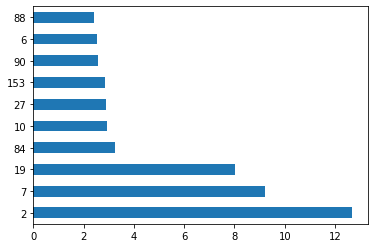

In [ ]:
pd.Series(model3.feature_importances_, index=x_train.columns).nlargest(10).plot(kind='barh')

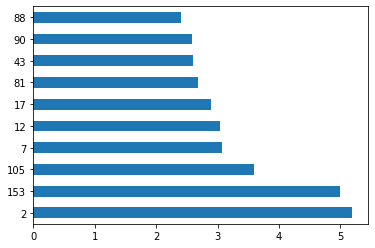

In [ ]:
pd.Series(model_3.feature_importances_, index=x_train.columns).nlargest(10).plot(kind='barh')